In [0]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip', 'train2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Finished unzipping val2017.zip
Finished downloading train2017.zip . Starting to unzip.
Finished unzipping train2017.zip
Done transferring all datasets


In [0]:
import json
set_name='val2017'
keypoint_data=json.load(open('annotations/person_keypoints_'+set_name+'.json'))
image_dir=set_name

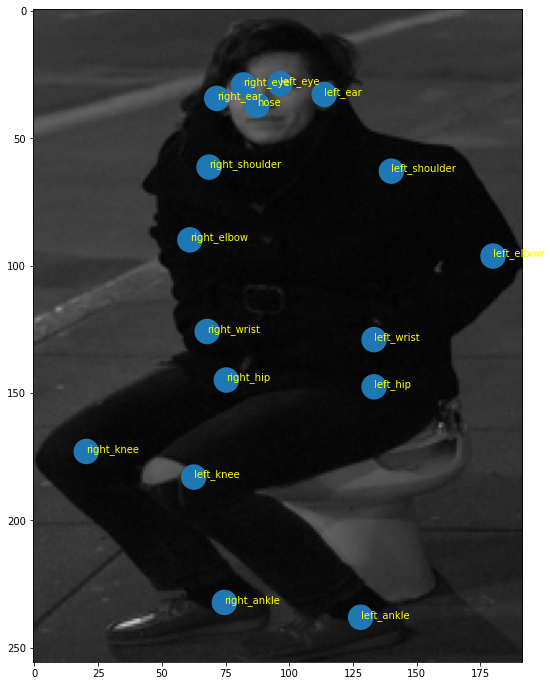

In [4]:
import PIL.Image, os
import matplotlib.pyplot as plt
from math import floor, ceil

def make_keypoint(i, keypoints):
  x = keypoints[i*3 + 0]
  y = keypoints[i*3 + 1]
  visible = keypoints[i*3 + 2]
  return (x,y,visible)

def keypoint_is_visible(i, keypoints):
  x,y,visible = make_keypoint(i, keypoints)
  return visible==2

def visible_keypoints(keypoints):
  n_keypoints = len(keypoints)//3
  return [i for i in range(n_keypoints) if keypoint_is_visible(i, keypoints)]

def find_candidate_annotations(keypoint_data):
  def matches_keypoints(annotation):
    keypoints = annotation['keypoints']
    n_keypoints = len(keypoints)//3
    n_visible = len(visible_keypoints(keypoints))
    return n_visible==n_keypoints
  annotations = keypoint_data['annotations']
  matching_annotations=[a for a in annotations if matches_keypoints(a)]
  return matching_annotations

def find_person_keypoints(keypoint_data):
  categories=keypoint_data['categories']
  category=[c for c in categories if c['supercategory']=='person'][0]
  category_keypoints=category['keypoints']
  return category_keypoints

def load_image(image_id, keypoint_data, image_dir):
  keypoint_images=keypoint_data['images']
  keypoint_image=[x for x in keypoint_images if x['id']==image_id][0]
  image_filename=keypoint_image['file_name']
  image_path=os.path.join(image_dir,image_filename)
  image=PIL.Image.open(image_path)
  return image

def make_crop(bbox):
  bbox_x = bbox[0]
  bbox_y = bbox[1]
  bbox_width = bbox[2]
  bbox_height = bbox[3]
  crop_x=floor(bbox_x)
  crop_y=floor(bbox_y)
  crop_width=ceil(bbox_x+bbox_width)-floor(bbox_x)
  crop_height=ceil(bbox_y+bbox_height)-floor(bbox_y)
  return (crop_x, crop_y, crop_width, crop_height)

def crop_and_resize_image(image, crop, new_size):
  new_width, new_height = new_size
  crop_x, crop_y, crop_width, crop_height = crop
  image=image.crop((crop_x,crop_y,crop_x+crop_width,crop_y+crop_height))
  image=image.resize((new_width,new_height))
  return image

def annotate_keypoints(figure, keypoints, keypoint_names, scale, crop):
  scale_x, scale_y = scale
  for i in visible_keypoints(keypoints):
    x,y,visible = make_keypoint(i, keypoints)
    adjusted_x=(x-crop_x)*scale_x
    adjusted_y=(y-crop_y)*scale_y
    circle=plt.Circle((adjusted_x,adjusted_y))
    figure.axes.add_patch(circle)
    figure.axes.text(adjusted_x,adjusted_y,keypoint_names[i],color='yellow')

which_candidate_annotation=1
final_width=192
final_height=256
new_size = (final_width, final_height)
keypoint_names = find_person_keypoints(keypoint_data)
candidate_annotations = find_candidate_annotations(keypoint_data)
annotation = candidate_annotations[which_candidate_annotation]
keypoints = annotation['keypoints']
bbox = annotation['bbox']
image_id = annotation['image_id']
crop = make_crop(bbox)
crop_x, crop_y, crop_width, crop_height = crop
image = load_image(image_id, keypoint_data, image_dir)
image = crop_and_resize_image(image, crop, new_size)
scale_x = final_width/crop_width
scale_y = final_height/crop_height
plt.figure(figsize=(12,12))
figure=plt.imshow(image)
annotate_keypoints(figure, keypoints, keypoint_names, (scale_x,scale_y), crop)